# Spitzer-ulens Tutorial Notebook
This notebook aims to demonstrate the usage of the the Spitzer-ulens package for observations with parallax.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import pickle
import emcee
import time as ti
from tqdm import tqdm
import os
from multiprocessing import Pool
import corner
from scipy import optimize as opt
import random

from Spitzer_ulens import data_config
from Spitzer_ulens import models
from Spitzer_ulens import PLD

## Configuration and Preparation

This section demonstrates usage of the 'data_config' module.

In [2]:
coords = ('17:47:31.93','-24:31:21.6')
data_path = 'data/ob171140/rawdata/'

In [3]:
load_evt_from_file = True
if load_evt_from_file:
    fname = 'ob171140.pkl'
    with open(fname,'rb') as file:
        evt = pickle.load(file)
else:
    # Create a PLDEventData object from our data
    evt = data_config.PLDEventData(data_path,coords,recursive=True)
    # Save our PLDEventData object
    evt.save(filepath='ob171140.pkl',overwrite=True)

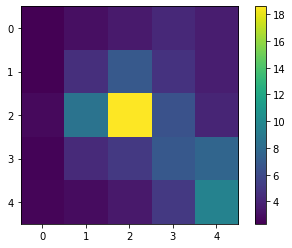

In [4]:
# Plotting an example of a 5-by-5 image
fig,ax = plt.subplots()
im = ax.imshow(evt.img[5][10])
fig.colorbar(im)
plt.show()

Text(0.5, 1.0, 'Spitzer Data')

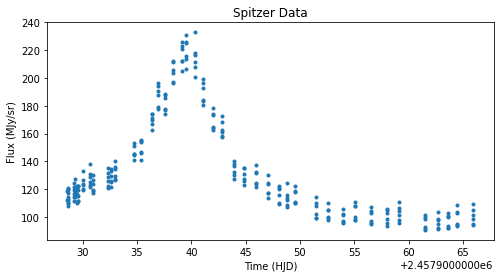

In [5]:
# Get raw photometry, error, and binned error
flux,flux_err,flux_frac,flux_scatter = evt.aperture_photometry()
time = np.array(evt.time)
ind = time<8000
time = (time[ind]+2450000).reshape(6,-1)
flux = flux[ind].reshape(6,-1)
flux_err = flux_err[ind].reshape(6,-1)
flux_frac = flux_frac[ind].reshape(6,-1,5,5)

# Plot our raw data
fig,ax = plt.subplots(figsize=(8,4))

ax.plot(time.ravel(),flux.ravel(),'C0.')
ax.set_xlabel('Time (HJD)')
ax.set_ylabel('Flux (MJy/sr)')
ax.set_title('Spitzer Data')

## Least-Squares Fit

In this section we do a least-squares fit to obtain some better parameter estimates. These will eventually become initial parameters for the MCMC fit. In this section we introduce the 'models' module.

In [32]:
# Make an initial guess for model parameters, which will be used as starting point for the least-squares fit. 
# I got these values from S. Calchi Novati et al 2018 AJ 155 261.

tE    = 14.58       # einstein radius crossing time
t0    = 2457940.195    # time of peak magnification
fb    = 76          # baseline flux
fs    = 21          # source flux
s     = 0.815       # separation between the two lenses (in Einstein radius of total mass)
q     = 0.0099      # mass ratio: Right-lens' mass divided by left-lens' mass
rho   = 1e-6        # source radius in Einstein radii of the total mass.
alpha = np.pi-2.561 # angle between lens axis and source trajectory (rad) VBBL_alpha = PI-OSU_alpha
u0    = 0.1343      # impact parameter

p0 = np.array([tE,t0,fb,fs,s,q,rho,alpha,u0])

# Specify some (loose) bounds on our parameters.
bounds = ([0,2457930,0,0,0,0,0,-np.inf,-np.inf],
          [np.inf,2457950,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf])

# Parameter labels
plabels = ['t_E','t_0','f_b','f_s','s','q',r'rho',r'alpha','u_0']

Text(0.5, 1.0, 'Spitzer Data Fit')

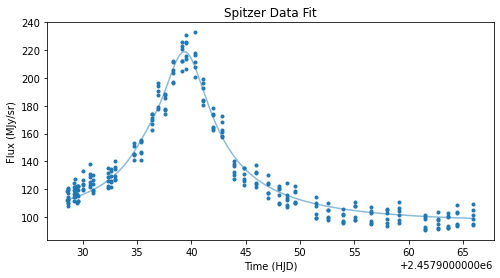

In [7]:
model = models.BinaryLensModel()

popt_lsq,cov = opt.curve_fit(model,time.ravel(),flux.ravel(),p0,bounds=bounds)

timeplot = np.linspace(np.min(time),np.max(time),1000)

fig,ax = plt.subplots(figsize=(8,4))

ax.plot(timeplot,model(timeplot,*popt_lsq),'C0',alpha=0.5)
ax.plot(time.ravel(),flux.ravel(),'C0.')
ax.set_xlabel('Time (HJD)')
ax.set_ylabel('Flux (MJy/sr)')
ax.set_title('Spitzer Data Fit')

## Solving PLD Coefficients Analytically

In [8]:
# Solve for PLD coefficients analytically (X)
astro, pld_coeffs, A, C = PLD.analytic_solution(time,flux,flux_err,flux_frac,popt_lsq,model)
# Get detector model and divide it out to get new best-fit
fit,sys,corr,resi = PLD.get_bestfit(pld_coeffs, flux, flux_frac, astro, A)

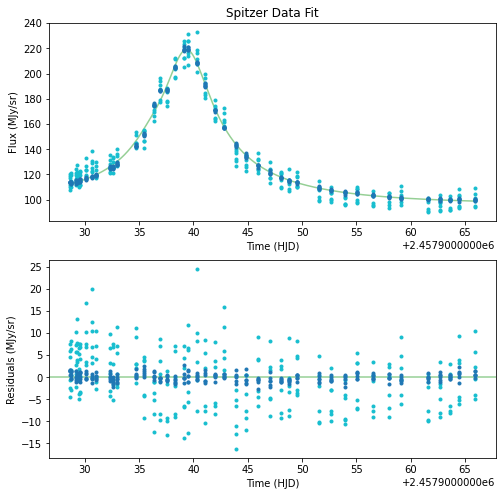

In [42]:
def plot_analytic_sol(model,time,popt,astro,flux,corr):
    timeplot = np.linspace(np.min(time),np.max(time),1000)

    fig,ax = plt.subplots(nrows=2,figsize=(8,8))

    ax[0].plot(timeplot,model(timeplot,*popt),'C2',alpha=0.5)
    ax[0].plot(time.ravel(),flux.ravel(),'C9.')
    ax[0].plot(time.ravel(),corr.ravel(),'C0.')
    ax[0].set_xlabel('Time (HJD)')
    ax[0].set_ylabel('Flux (MJy/sr)')
    ax[0].set_title('Spitzer Data Fit')

    ax[1].axhline(c='C2',alpha=0.5)
    ax[1].plot(time.ravel(),flux.ravel()-astro.ravel(),'C9.')
    ax[1].plot(time.ravel(),corr.ravel()-astro.ravel(),'C0.')
    ax[1].set_xlabel('Time (HJD)')
    ax[1].set_ylabel('Residuals (MJy/sr)')
plot_analytic_sol(model,time,popt_lsq,astro,flux,corr)

# MCMC Fit for PLD Parameters

In this section we run a Markov Chain Monte-Carlo (MCMC) fit to our data. This will explore parameter space to optimize the log-likelihood for our model to fit our data. We use the emcee package (https://github.com/dfm/emcee) to do our fit. The log-likelihood function we use is a method of the SingleLensParallaxModel class, as detailed in the 'Spitzer_ulens.models' module.

In [10]:
def run_mcmc(sampler,pos0,nsteps,visual=True,label=''):
    if visual:
        tic = ti.time()
        print('Running MCMC '+label+'...')
        
        # Using tqdm package to generate progress bars
        for pos, prob, state in tqdm(sampler.sample(pos0, iterations=nsteps),total=nsteps):
            pass

        print("Mean burn-in acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
        toc = ti.time()
        print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))
        return pos,prob,state
    else:
        pos,prob,state = sampler.run_mcmc(pos0,nsteps)
        return pos,prob,state

In [11]:
def get_MCMC_results(pos_chain,lnp_chain):
    _,_,npars = pos_chain.shape
    posit = pos_chain.reshape(-1,npars)

    # Get the percentile
    percs = np.percentile(posit, [16, 50, 84],axis=0)
    (MCMC_Results) = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*percs))))

    popt = MCMC_Results[:,0]
    std_hi = MCMC_Results[:,1]
    std_lo = MCMC_Results[:,2]

    # Get most probable params
    probs = lnp_chain.flatten()
    pmax = posit[np.argmax(probs)]
    
    return popt,pmax,std_hi,std_lo

In [12]:
load_chain_from_file = True
savepath = 'out/2lens'

if load_chain_from_file:
    pos_chain = np.load(os.path.join(savepath,'samplerchain.npy'))
    lnp_chain = np.load(os.path.join(savepath,'samplerlnpro.npy'))
else:
    p0 = popt_lsq
    nwalkers = 100
    nburnin = 300
    nprod = 1000
    
    # Generate the MCMC sampler with 100 walkers, our log-probability function, and our data. We
    # use pool from the multiprocessing package to parallelize the process.
    sampler = emcee.EnsembleSampler(nwalkers, len(p0), model.lnprob, a = 2, pool=Pool(),
                                    args=(bounds,time,flux,flux_err,flux_frac,
                                          flux_scatter))
    
    # Initialize the initial parameter positions for each walker by adding a random offset. Starting
    # our walkers in different positions allows us to explore more parameter space.
    pos0 = [p0*(1+1e-5*np.random.randn(sampler.ndim))+1e-5*np.abs(np.random.randn(sampler.ndim)) 
            for i in range(sampler.nwalkers)]
    
    # Run the first MCMC burn-in.
    pos1,prob,state = run_mcmc(sampler,pos0,nburnin,label='first burn-in')
    sampler.reset()

    #Run the MCMC from best spot from last time, and do another burn-in to get the walkers spread out.
    pos2 = pos1[np.argmax(prob)]
    
    # Slightly change position of walkers to prevent them from taking the same path
    pos2 = [pos2*(1+1e-6*np.random.randn(sampler.ndim))+1e-6*np.abs(np.random.randn(sampler.ndim)) 
            for i in range(sampler.nwalkers)]
    
    # Run the second burn-in
    pos2, prob, state = run_mcmc(sampler,pos2,nburnin,label='second burn-in')
    sampler.reset()
    
    #Run the final production run that will be saved
    pos_final, prob, state = run_mcmc(sampler,pos2,nprod,label='production')

    pos_chain = sampler.chain
    lnp_chain = sampler.lnprobability
    
    np.save(savepath+'/samplerchain.npy',pos_chain)
    np.save(savepath+'/samplerlnpro.npy',lnp_chain)
    
# Get results from chain
popt_mcmc,pmax,std_hi,std_lo = get_MCMC_results(pos_chain,lnp_chain)

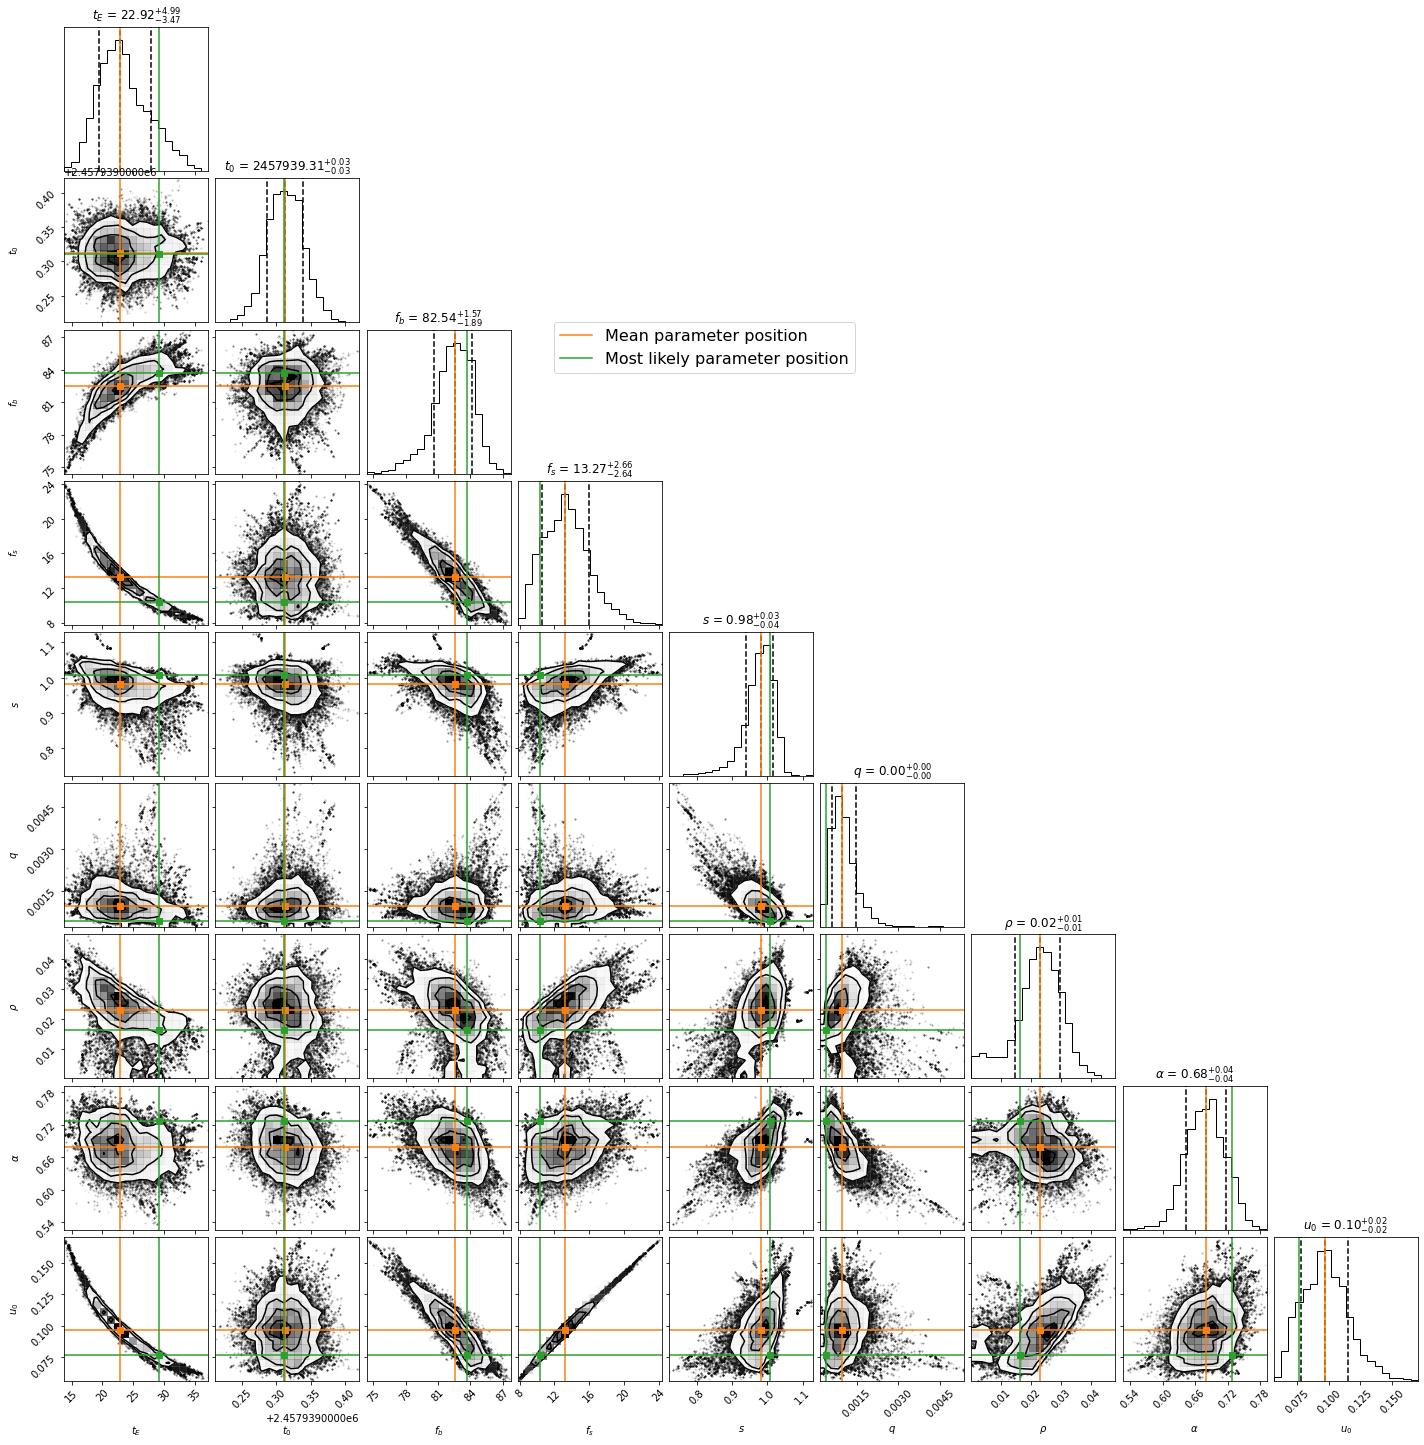

In [17]:
# Create corner plots to check for convergence
# 1d array of samples
samples = pos_chain.reshape((-1, len(popt_mcmc)))

# corner plot
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, plot_datapoints=True, 
                    title_kwargs={"fontsize": 12},labels=plabels)

corner.overplot_lines(fig, popt_mcmc, color="C1", label='Mean parameter position')
corner.overplot_points(fig, popt_mcmc[None], marker="s", color="C1")
corner.overplot_lines(fig, pmax, color="C2", label='Most likely parameter position')
corner.overplot_points(fig, pmax[None], marker="s", color="C2")

plt.legend(loc=(-5,7),fontsize=16)

In [ ]:
# Re-run MCMC if it does not look converged. This cell can be run repeatedly.
rerun_mcmc = True
if rerun_mcmc:
    nwalkers = 100
    nprod = 1000
    
    sampler = emcee.EnsembleSampler(nwalkers, len(p0), model.lnprob, a = 2, pool=Pool(),
                                    args=(bounds,time,flux,flux_err,flux_frac,
                                          flux_scatter))
    pos0 = pos_chain[:,-1,:]

    pos_final,prob_final,state_final = run_mcmc(sampler,pos0,nprod,label='production')

    pos_chain = sampler.chain
    lnp_chain = sampler.lnprobability
    
    popt_mcmc,pmax,std_hi,std_lo = get_MCMC_results(pos_chain,lnp_chain)
    
    np.save(savepath+'/samplerchain.npy',pos_chain)
    np.save(savepath+'/samplerlnpro.npy',lnp_chain)

In [71]:
# Reporting best-fit parameters
def pretty_print(popt,pmax,std_hi,std_lo,labels):
    tab = np.transpose([labels,popt,pmax,std_hi,std_lo])
    print('\t%s\t\t%s\t%s\t\t%s'%('Mean Parameter','Most Likely Parameter',r'Upper 1 sigma',r'Lower 1 sigma'))
    for row in tab:
        print('%s\t%s\t%s\t%s\t%s'%(row[0],row[1],row[2],row[3],row[4]))
pretty_print(popt_mcmc,pmax,std_hi,std_lo,plabels)

	Mean Parameter		Most Likely Parameter	Upper 1 sigma		Lower 1 sigma
t_E	22.916837287057753	29.161667718077897	4.99036675021452	3.4724119506548163
t_0	2457939.3130413485	2457939.311498556	0.02599700028076768	0.02607052866369486
f_b	82.53656531955357	83.70286798440455	1.5736947103413996	1.8855031041971984
f_s	13.269272171065069	10.406942915740705	2.6628897825170075	2.6404249321261837
s	0.9814296320500457	1.0061023215022415	0.033628568278163185	0.04358440133872232
q	0.000967898387707551	0.0004192792299177382	0.0004962695657463633	0.0003439070823009207
rho	0.022975128764596363	0.01629962402696235	0.006820577109976994	0.008253999067524755
alpha	0.6794831861853814	0.7273534174633102	0.036675212069037344	0.03653729886431889
u_0	0.09657864877149994	0.0765985241855717	0.0185037626189037	0.01855411518401759


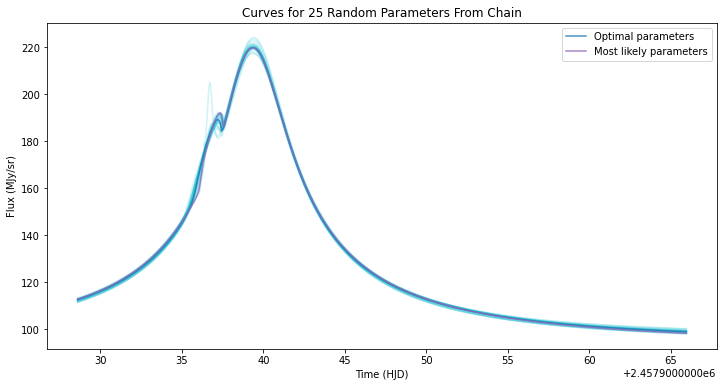

In [72]:
def plot_random_curves(pos_chain,model,timeplot,popt=None,pmax=None,ncurves=1,seed=None,figsize=(8,4)):
    fig,ax = plt.subplots(figsize=figsize)
    nwalkers,nsteps,npars = np.shape(pos_chain)
    chain = pos_chain.reshape(nwalkers*nsteps,-1)
    for i in range(ncurves):
        pars = random.choice(chain)
        ax.plot(timeplot,model(timeplot,*pars),alpha=0.2,c='C9')
    ax.set_title('Curves for %i Random Parameters From Chain'%ncurves)
    ax.set_xlabel('Time (HJD)')
    ax.set_ylabel('Flux (MJy/sr)')
    if popt is not None:
        ax.plot(timeplot,model(timeplot,*popt),alpha=0.8,c='C0',label='Optimal parameters')
    if pmax is not None:
        ax.plot(timeplot,model(timeplot,*pmax),alpha=0.8,c='C4',label='Most likely parameters')
    ax.legend()
        
plot_random_curves(pos_chain,model,timeplot,popt=popt_mcmc,pmax=pmax,ncurves=25,figsize=(12,6))

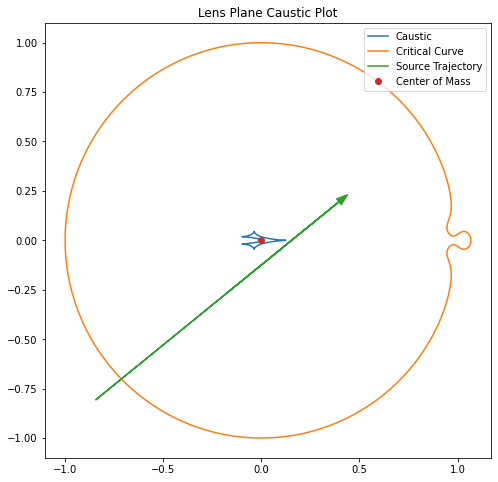

In [70]:
def plot_caustics(pars,figsize=(8,8)):
    caus,crit,y = model.get_caustics(time,*pars[[0,1,4,5,6,7,8]])
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(caus[:,0],caus[:,1],label='Caustic',c='C0')
    ax.plot(crit[:,0],crit[:,1],label='Critical Curve',c='C1')
    ax.plot(y[:,0],y[:,1],label='Source Trajectory',c='C2')
    ax.plot(0,0,'o',label='Center of Mass',c='C3')
    dx = y[:,0][-1]-y[:,0][0]
    dy = y[:,1][-1]-y[:,1][0]
    ax.arrow(y[:,0][0],y[:,1][0],dx,dy,head_width=0.04, head_length=0.06,fc='C2',ec='C2')
    ax.set_title('Lens Plane Caustic Plot')
    ax.legend()
    
plot_caustics(popt_mcmc)

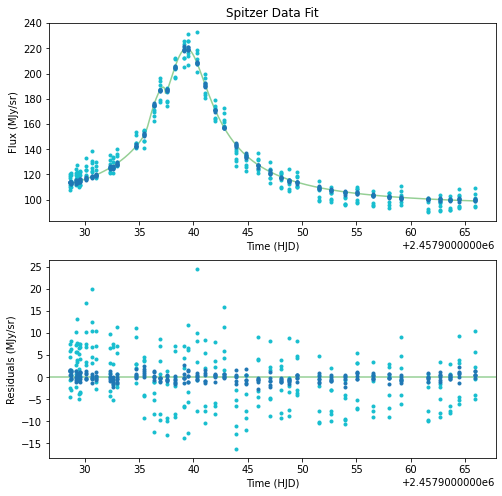

In [43]:
# Final analytic solution for corrected data
astro, pld_coeffs, A, C = PLD.analytic_solution(time,flux,flux_err,flux_frac,popt_mcmc,model)
# Get detector model and divide it out to get new best-fit
fit,sys,corr,resi = PLD.get_bestfit(pld_coeffs, flux, flux_frac, astro, A)
plot_analytic_sol(model,time,popt_mcmc,astro,flux,corr)